In [ ]:
! pip install pymc3 daft

In [15]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# UTILITY FUNCTION

def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement"""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

In [9]:
df = pd.read_csv("https://github.com/facebook/prophet/raw/main/examples/example_air_passengers.csv", parse_dates=["ds"])

<AxesSubplot:xlabel='ds', ylabel='y'>

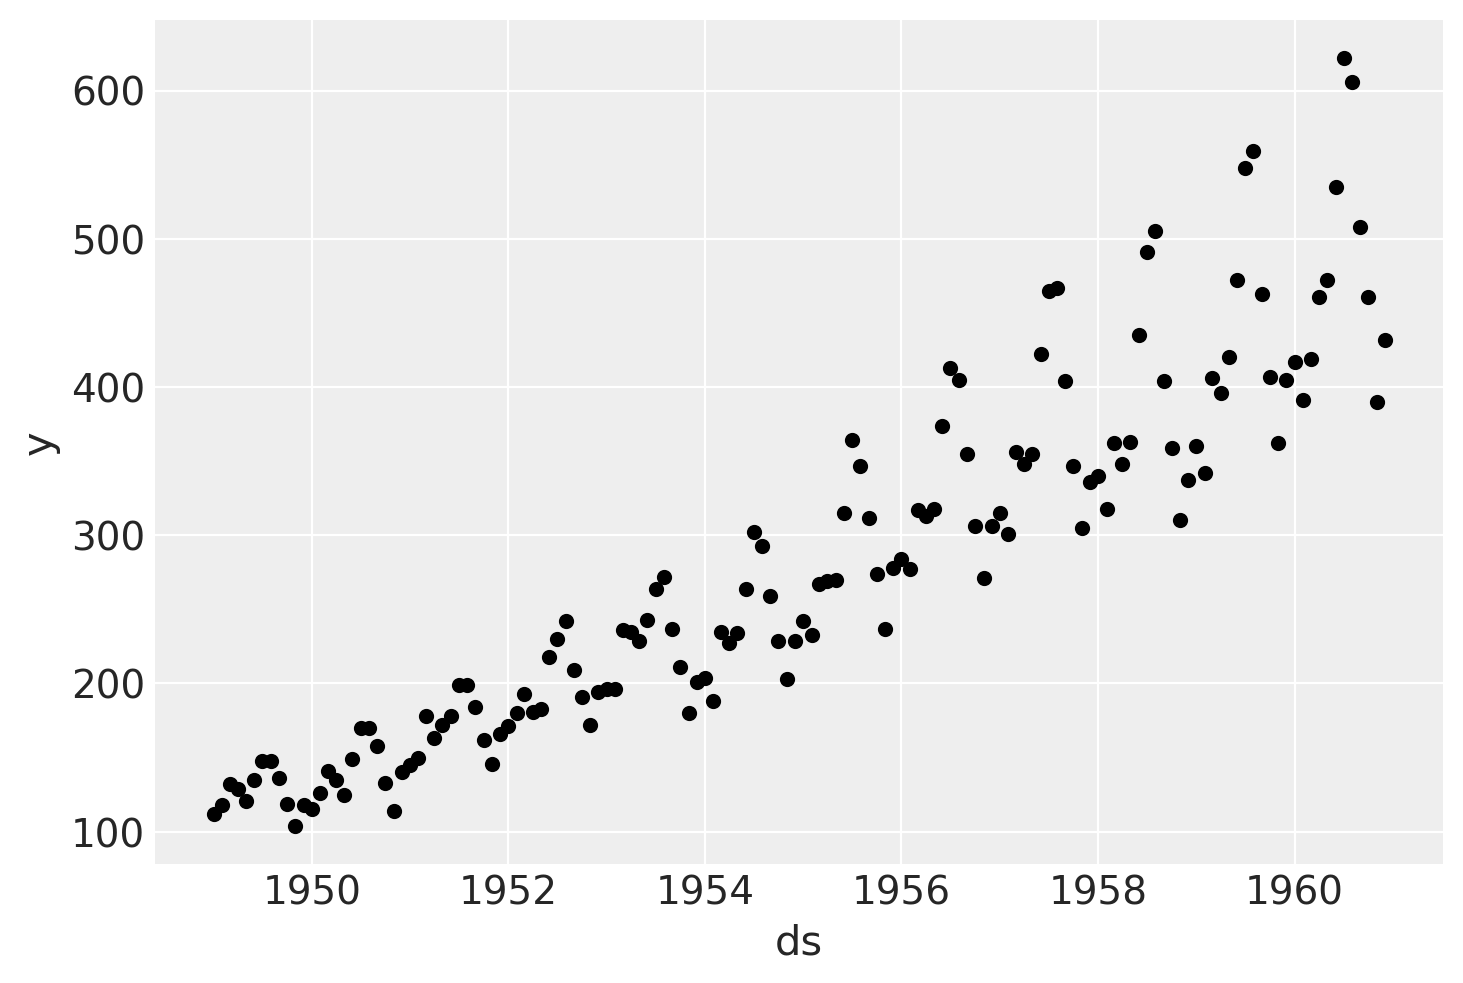

In [10]:
df.plot.scatter(x="ds", y="y", color="k")

In [12]:
# SCALE THE DATA

# Time
t = (df["ds"] - pd.Timestamp("1900-01-01")).dt.total_seconds().to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

# Number of passengers
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

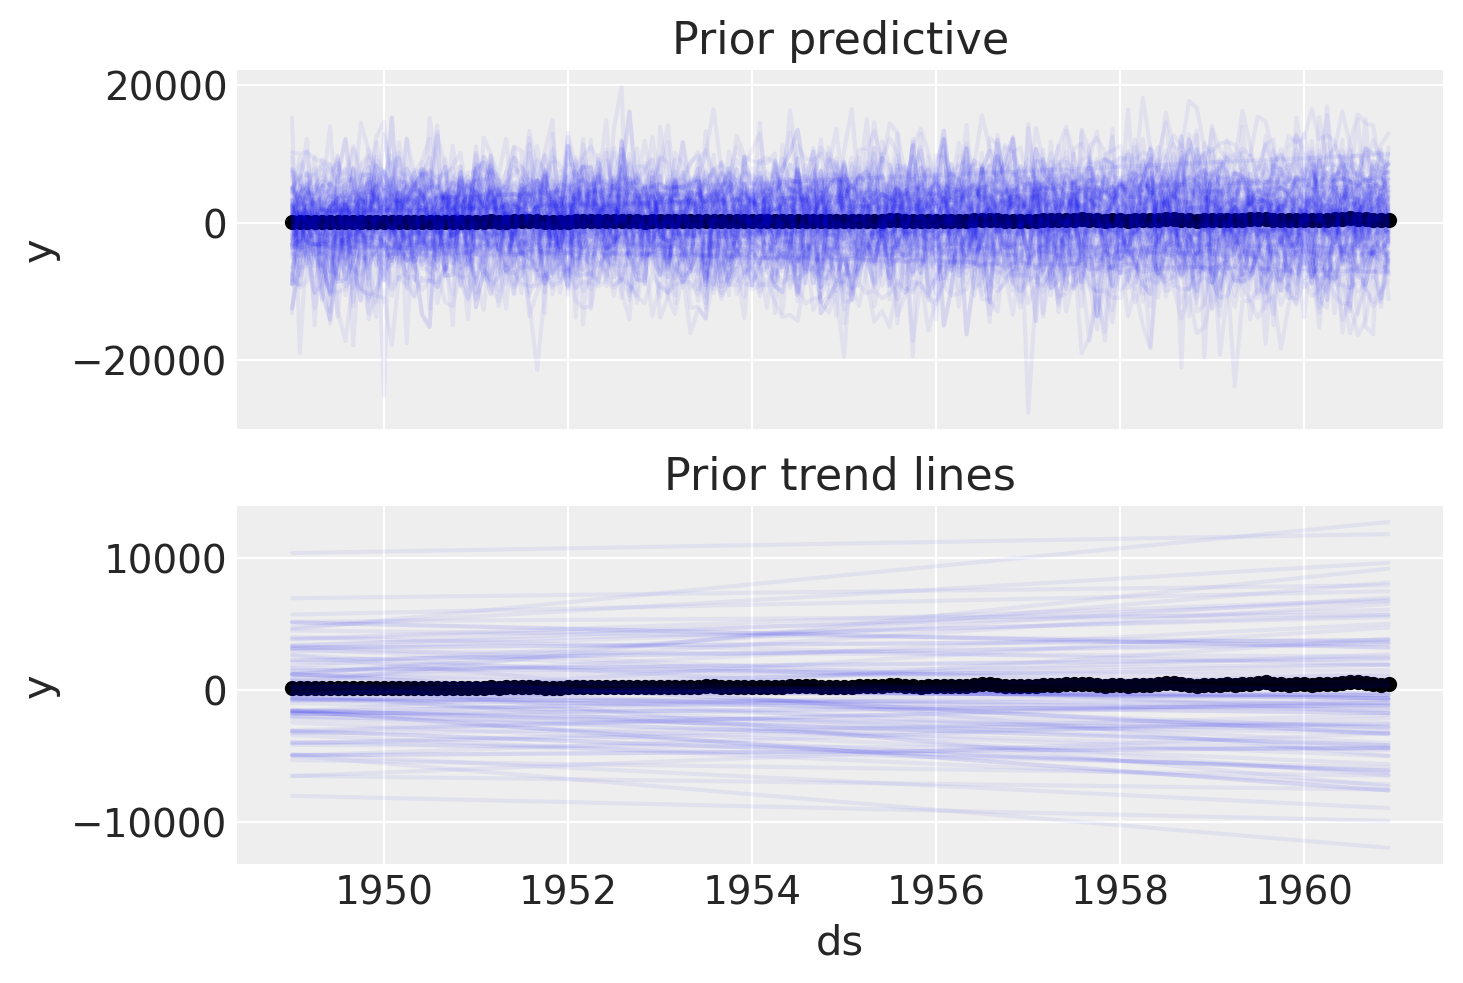

In [16]:
# WITH LARGE DEFAULT VARIANCE

with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=5)
    β = pm.Normal("β", mu=0, sigma=5)
    σ = pm.HalfNormal("σ", sigma=5)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior_predictive = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["ds"],
    _sample(linear_prior_predictive["likelihood"], 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["ds"], _sample(linear_prior_predictive["trend"], 100).T * y_max, color="blue", alpha=0.05
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

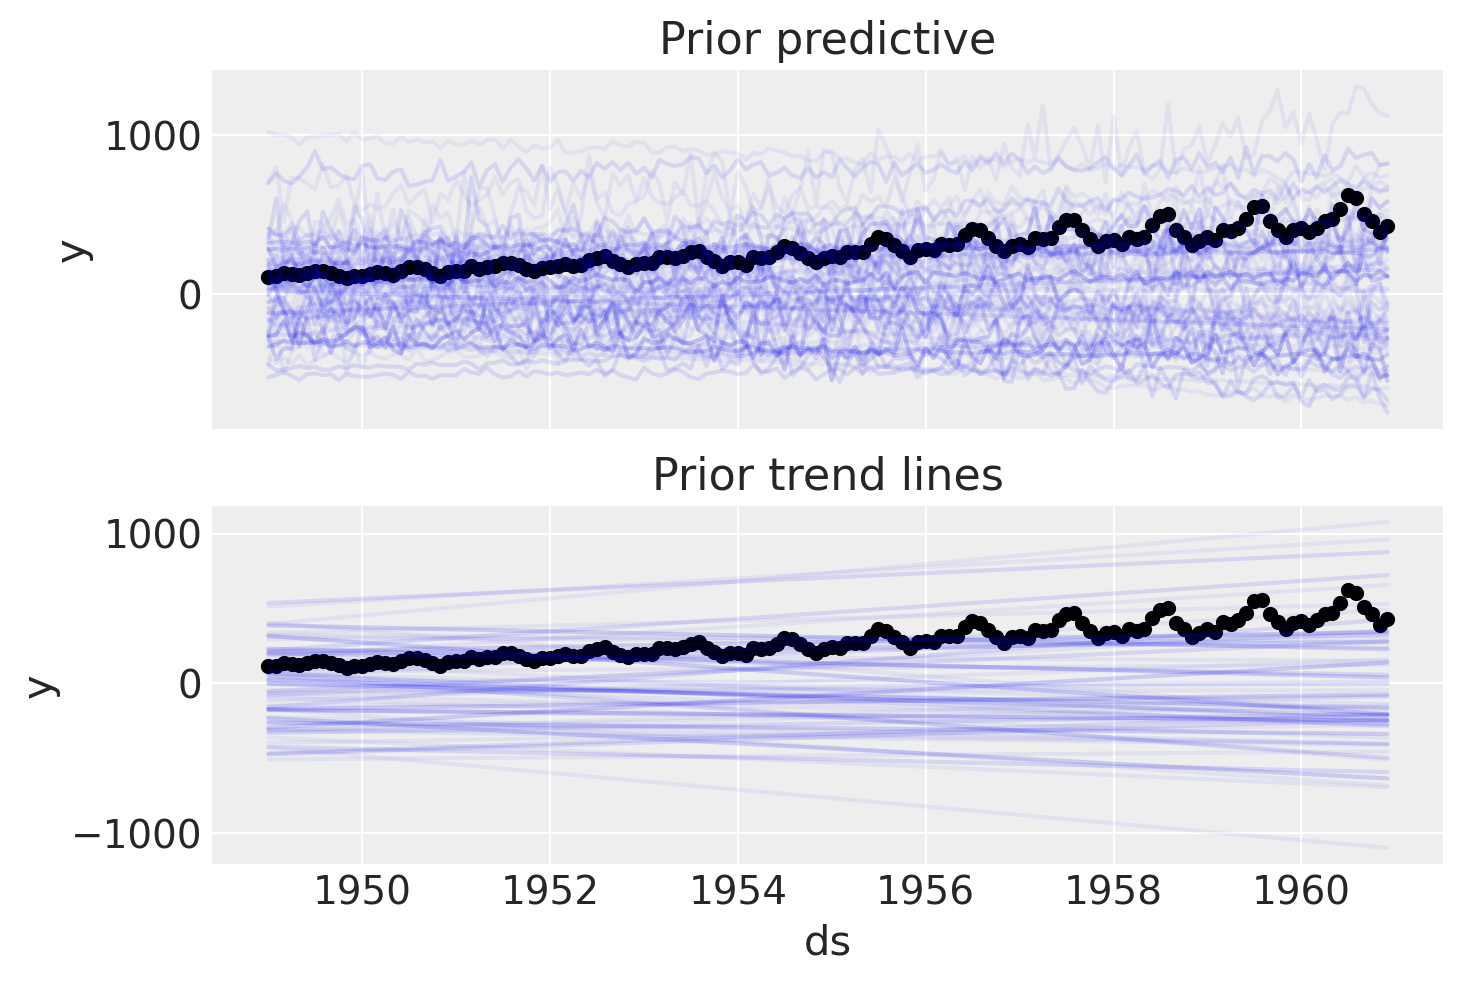

In [18]:
# WITH REDUCED VARIANCE IN PRIOR

with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.1)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior_predictive = pm.sample_prior_predictive(samples=100)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["ds"],
    _sample(linear_prior_predictive["likelihood"], 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["ds"], _sample(linear_prior_predictive["trend"], 100).T * y_max, color="blue", alpha=0.05
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8891395072449793, but should be close to 0.8. Try to increase the number of tuning steps.


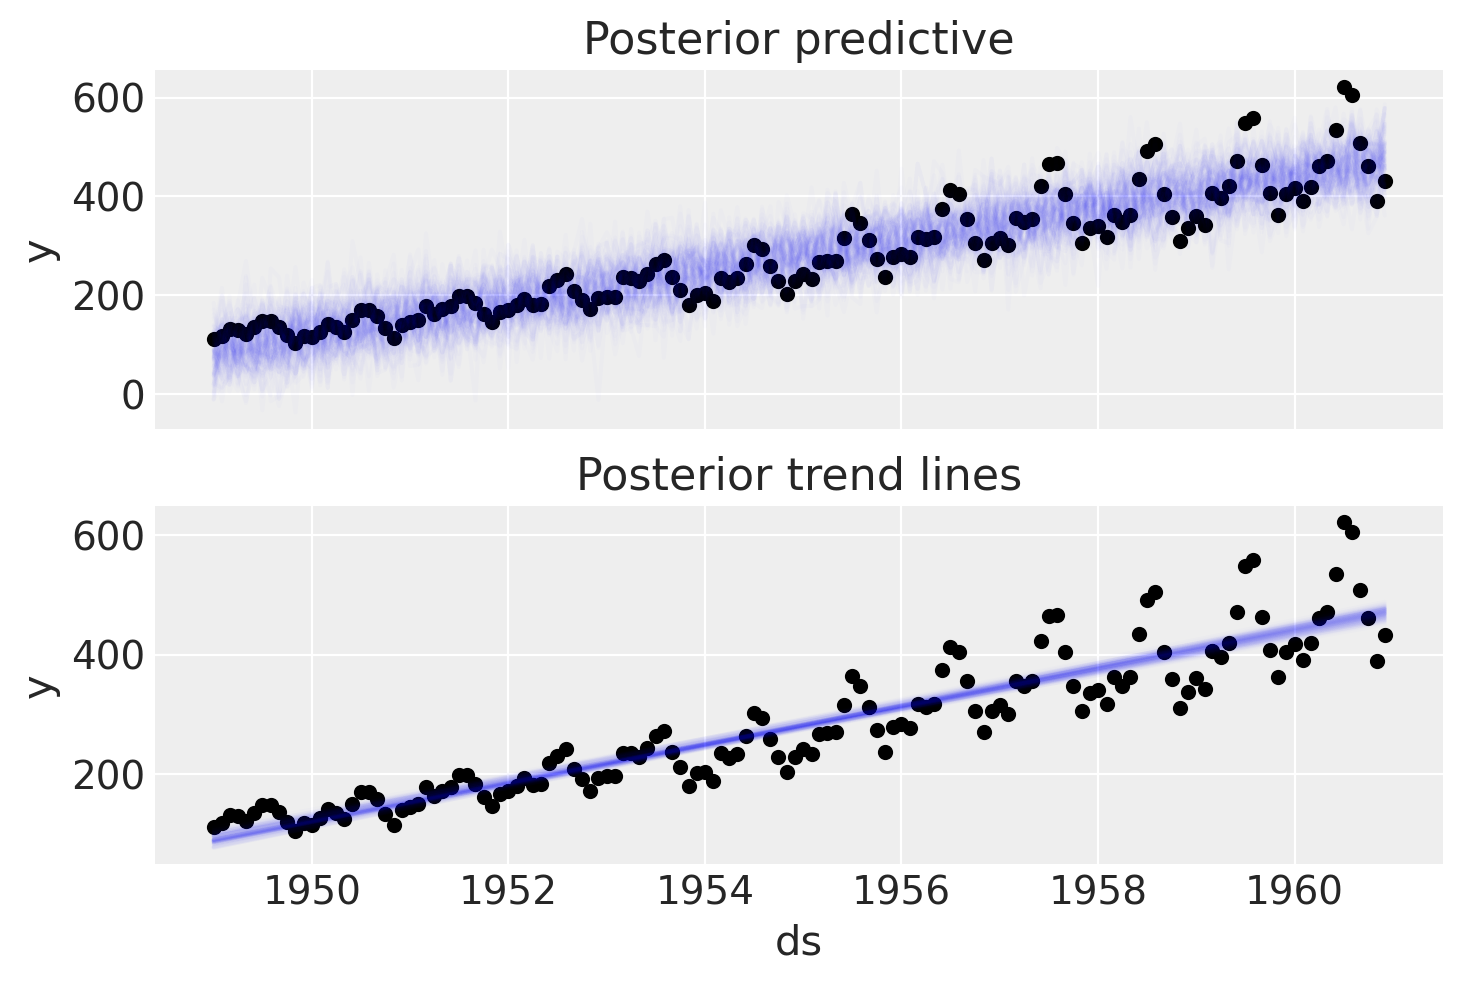

In [19]:
# POSTERIOR CHECK

with linear:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_posterior_predictive = pm.sample_posterior_predictive(trace=linear_trace)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["ds"],
    _sample(linear_posterior_predictive["likelihood"], 100).T * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
posterior_trend = linear_trace.posterior["trend"].stack(sample=("draw", "chain")).T
ax[1].plot(df["ds"], _sample(posterior_trend, 100).T * y_max, color="blue", alpha=0.01)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");

In [21]:
n_order = 10
periods = df["ds"].dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
fourier_features

,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3,sin_order_4,cos_order_4,sin_order_5,cos_order_5,sin_order_6,cos_order_6,sin_order_7,cos_order_7,sin_order_8,cos_order_8,sin_order_9,cos_order_9,sin_order_10,cos_order_10
0,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303,0.103031,0.994678,0.120126,0.992759,0.137185,0.990545,0.154204,0.988039,0.171177,0.985240
1,0.523094,0.852275,0.891640,0.452745,0.996751,-0.080549,0.807371,-0.590044,0.379453,-0.925211,-0.160575,-0.987024,-0.653160,-0.757220,-0.952769,-0.303695,-0.970882,0.239557,-0.702148,0.712031
2,0.858402,0.512978,0.880683,-0.473706,0.045141,-0.998981,-0.834370,-0.551205,-0.901169,0.433469,-0.090190,0.995925,0.808638,0.588307,0.919817,-0.392347,0.135055,-0.990838,-0.781257,-0.624210
3,0.999986,0.005376,0.010751,-0.999942,-0.999870,-0.016127,-0.021501,0.999769,0.999639,0.026876,0.032249,-0.999480,-0.999292,-0.037621,-0.042993,0.999075,0.998830,0.048363,0.053732,-0.998555
4,0.872404,-0.488785,-0.852837,-0.522178,-0.038696,0.999251,0.890665,-0.454661,-0.831992,-0.554788,-0.077334,0.997005,0.907591,-0.419855,-0.809901,-0.586567,-0.115856,0.993266,0.923158,-0.384421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-0.513901,-0.857849,0.881699,0.471812,-0.998830,0.048363,0.831992,-0.554788,-0.428618,0.903486,-0.096613,-0.995322,0.594376,0.804187,-0.923158,-0.384421,0.989485,-0.144636,-0.774500,0.632573
140,-0.878637,-0.477489,0.839080,-0.544008,0.077334,0.997005,-0.912932,-0.408111,0.794497,-0.607268,0.154204,0.988039,-0.941759,-0.336289,0.745156,-0.666890,0.230151,0.973155,-0.964945,-0.262452
141,-0.999833,0.018277,-0.036547,-0.999332,0.998497,-0.054805,0.073045,0.997329,-0.995827,0.091261,-0.109446,-0.993993,0.991826,-0.127594,0.145700,0.989329,-0.986501,0.163757,-0.181760,-0.983343
142,-0.851712,0.524010,-0.892612,-0.450826,-0.083764,-0.996486,0.804826,-0.593511,0.927238,0.374474,0.166938,0.985967,-0.752283,0.658840,-0.955346,-0.295489,-0.248940,-0.968519,0.694452,-0.719539


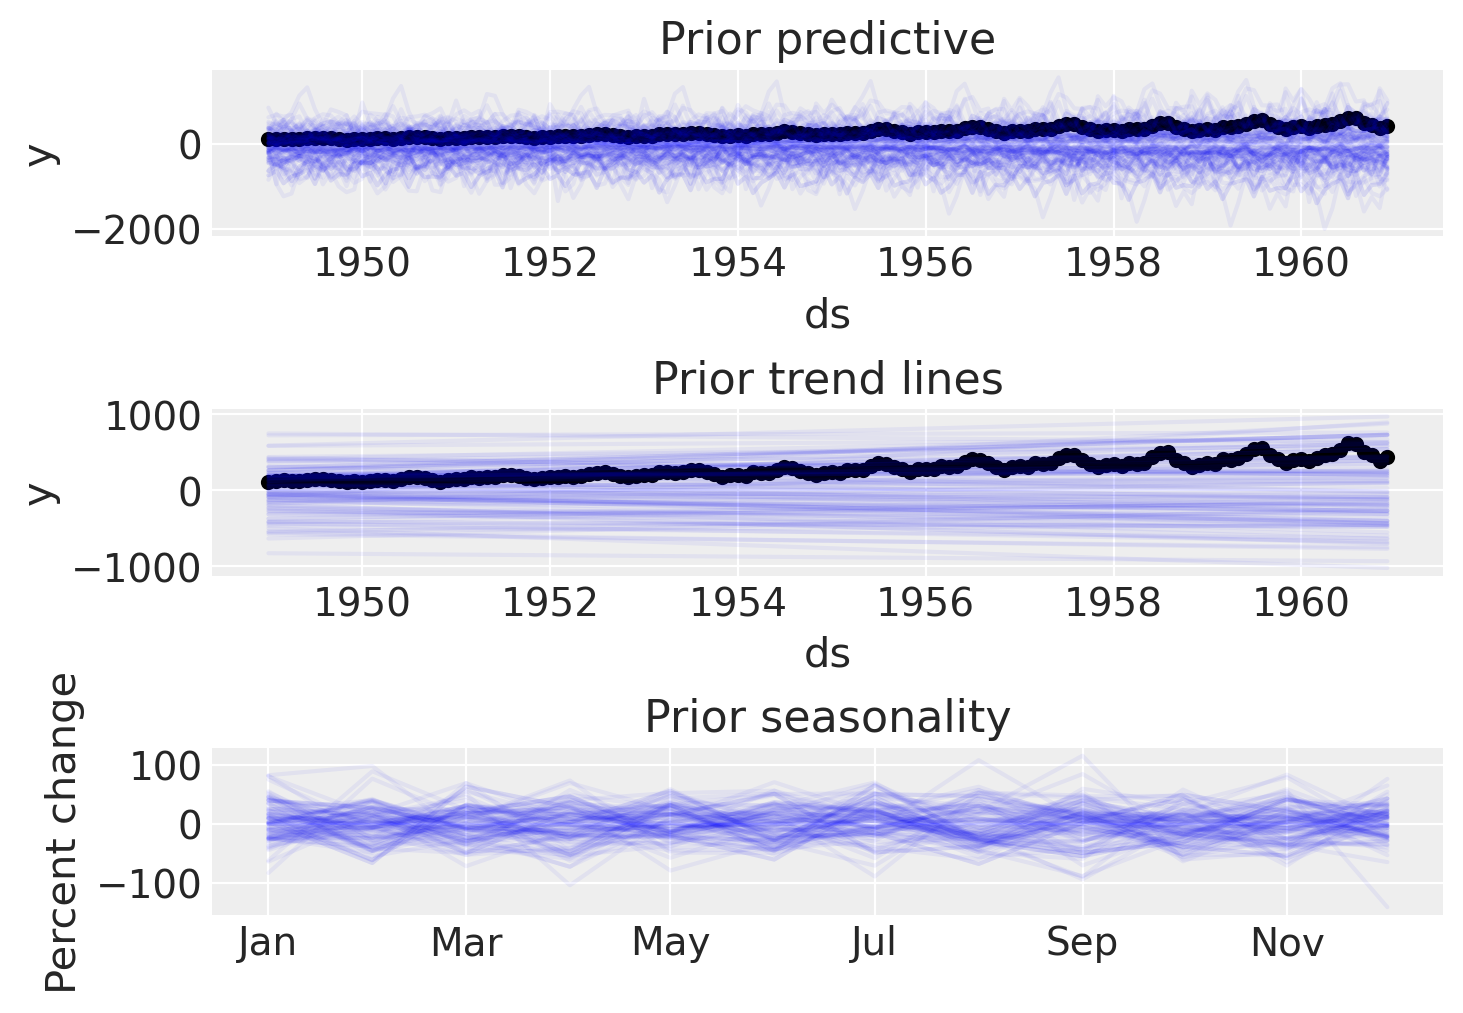

In [22]:
# BASED ON OUR PREFERRED PRIORS

coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    trend = pm.Deterministic("trend", α + β * t)

    β_fourier = pm.Normal("β_fourier", mu=0, sigma=0.1, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_features.to_numpy().T)
    )

    μ = trend * (1 + seasonality)
    σ = pm.HalfNormal("σ", sigma=0.1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_with_seasonality_prior_predictive = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False)
ax[0].plot(
    df["ds"],
    _sample(linear_with_seasonality_prior_predictive["likelihood"], 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["ds"],
    _sample(linear_with_seasonality_prior_predictive["trend"], 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    df["ds"].iloc[:12],
    _sample(linear_with_seasonality_prior_predictive["seasonality"][:, :12], 100).T * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_fourier, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


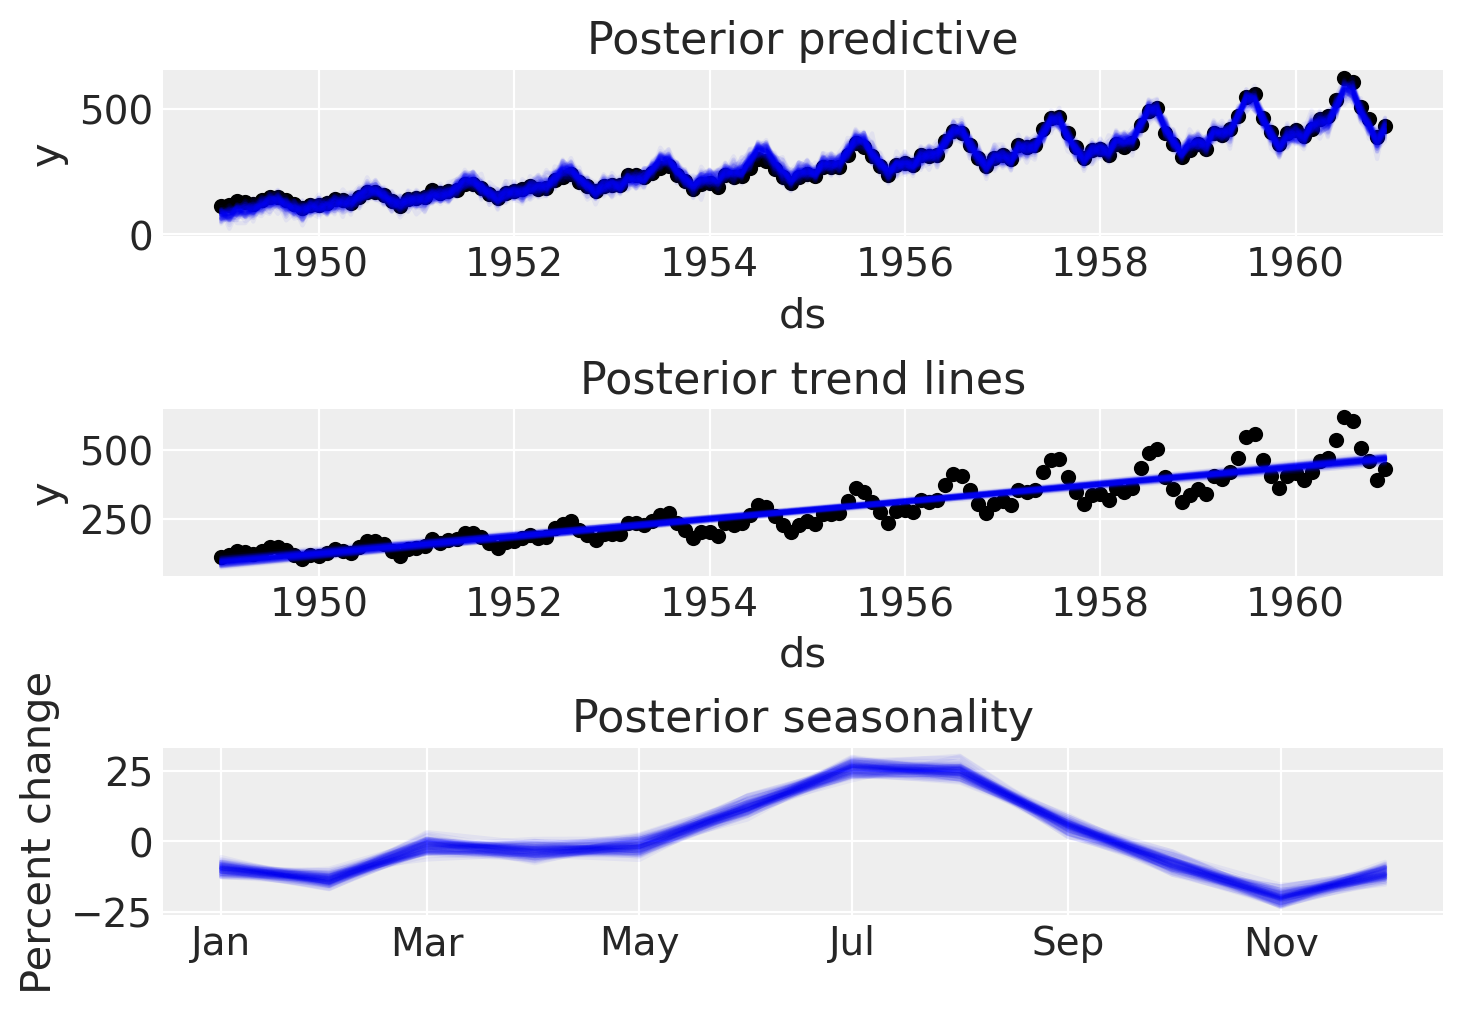

In [23]:
# POSTERIOR CHECK

with linear_with_seasonality:
    linear_with_seasonality_trace = pm.sample(return_inferencedata=True)
    linear_with_seasonality_posterior_predictive = pm.sample_posterior_predictive(
        trace=linear_with_seasonality_trace
    )

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False)
ax[0].plot(
    df["ds"],
    _sample(linear_with_seasonality_posterior_predictive["likelihood"], 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
posterior_trend = linear_trace.posterior["trend"].stack(sample=("draw", "chain")).T
ax[1].plot(df["ds"], _sample(posterior_trend, 100).T * y_max, color="blue", alpha=0.05)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines")
posterior_seasonality = (
    linear_with_seasonality_trace.posterior["seasonality"].stack(sample=("draw", "chain")).T
)
ax[2].plot(
    df["ds"].iloc[:12],
    _sample(posterior_seasonality[:, :12], 100).T * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Posterior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);